In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from collections import Counter
from string import punctuation

from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
#nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')

from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import skimage

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

from keras.preprocessing.image import (load_img
                                       , array_to_img
                                       , img_to_array
                                       , ImageDataGenerator)
import keras

Using TensorFlow backend.


In [2]:
file = open('photo.json', 'r')

In [3]:
stop = 200000
all_data = []

for i, line in enumerate(file):
    if i%200000 == 0:
        print(i)
    if i == stop:
        break
    
    data = json.loads(line)
    
    photo_id = data['photo_id']
    buz_id = data['business_id']
    caption = data['caption']
    label = data['label']
    
    all_data.append([photo_id
                     , buz_id
                     , caption
                     , label])
    
df_photos = pd.DataFrame(all_data, columns = ['photo_id'
                                              , 'buz_id'
                                              , 'caption'
                                              , 'label'])

file.close()

0


In [4]:
file = open('business.json', 'r')

In [5]:
# open input file: 
file = open('business.json') 

# read the first 10k entries
# set to -1 to process everything
stop = 192609

all_data = list()
for i, line in enumerate(file):
    if i%192609==0:
        print(i)
    if i==stop:
        break    
    # convert the json on this line to a dict
    data = json.loads(line)
    # extract what we want
    
    buz_id = data['business_id']
    names = data['name']
    reviews = data['review_count']
    stars = data['stars']
    state = data['state']
    
    # add to the data collected so far
    all_data.append([buz_id
                     , names
                     , reviews
                     , stars
                     , state])
    
# create the DataFrame
df_businesses = pd.DataFrame(all_data, columns=['buz_id'
                                                , 'name'
                                                , 'review_count'
                                                , 'stars'
                                                , 'state'])

file.close()

0


In [6]:
df = pd.merge(df_photos, df_businesses, on='buz_id')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 8 columns):
photo_id        200000 non-null object
buz_id          200000 non-null object
caption         200000 non-null object
label           200000 non-null object
name            200000 non-null object
review_count    200000 non-null int64
stars           200000 non-null float64
state           200000 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 13.7+ MB


In [8]:
df.head(1)

,photo_id,buz_id,caption,label,name,review_count,stars,state
0,MllA1nNpcp1kDteVg6OGUw,rcaPajgKOJC2vo_l3xa42A,,inside,Bouchon,3859,4.0,NV


In [9]:
df_stars = pd.DataFrame(df.stars.value_counts())

In [10]:
df_stars

,stars
4.0,67475
3.5,46303
4.5,36668
3.0,24888
2.5,11118
2.0,6421
5.0,3163
1.5,3045
1.0,919


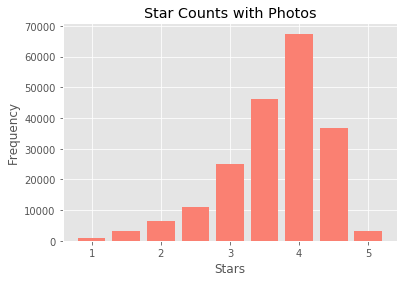

In [11]:
width=0.4
plt.bar(df_stars.index, df_stars.stars, width, color='salmon')
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.title('Star Counts with Photos')
plt.savefig('photo_ctn_with_photos.png');

In [12]:
df_state = pd.DataFrame(df.state.value_counts())

In [13]:
df_state

,state
NV,62837
ON,42719
AZ,39826
NC,12315
QC,12002
OH,11423
PA,8384
AB,5144
WI,3480
IL,1083


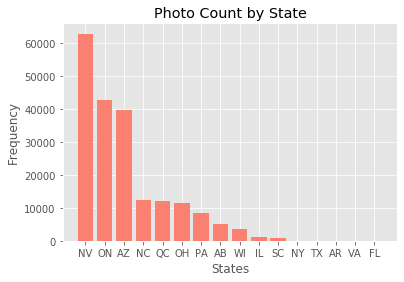

In [14]:
plt.bar(df_state.index, df_state.state, color='salmon')
plt.xlabel('States')
plt.ylabel('Frequency')
plt.title('Photo Count by State')
plt.savefig('photo_ctn_by_state.png');

In [15]:
df.groupby('stars')['state'].count()

stars
1.0      919
1.5     3045
2.0     6421
2.5    11118
3.0    24888
3.5    46303
4.0    67475
4.5    36668
5.0     3163
Name: state, dtype: int64

In [16]:
df_star_inside = pd.DataFrame(df.stars.loc[df.label == 'inside'].value_counts())

In [17]:
df_star_inside.rename(columns={'stars': 'inside'}, inplace=True)

In [18]:
df_star_inside

,inside
4.0,19314
3.5,12922
4.5,10549
3.0,6060
2.5,2007
5.0,961
2.0,511
1.5,103
1.0,21


In [19]:
df_star_food = pd.DataFrame(df.stars.loc[df.label == 'food'].value_counts())

In [20]:
df_star_food.rename(columns={'stars': 'food'}, inplace=True)

In [21]:
df_star_food

,food
4.0,36535
3.5,25468
4.5,20106
3.0,14819
2.5,7593
2.0,5226
1.5,2670
5.0,1637
1.0,820


In [22]:
df_star_menu =  pd.DataFrame(df.stars.loc[df.label == 'menu'].value_counts())

In [23]:
df_star_menu.rename(columns={'stars': 'menu'}, inplace=True)

In [24]:
df_star_menu

,menu
4.0,1039
3.5,696
4.5,655
3.0,419
2.5,120
5.0,55
2.0,34
1.5,4
1.0,1


In [25]:
df_star_drink = pd.DataFrame(df.stars.loc[df.label == 'drink'].value_counts())

In [26]:
df_star_drink.rename(columns={'stars': 'drink'}, inplace=True)

In [27]:
df_star_drink

,drink
4.0,6448
3.5,4197
4.5,3531
3.0,2093
2.5,869
2.0,420
5.0,297
1.5,202
1.0,64


In [28]:
df_star_outside = pd.DataFrame(df.stars.loc[df.label == 'outside'].value_counts())

In [29]:
df_star_outside.rename(columns={'stars': 'outside'}, inplace=True)

In [30]:
df_star_outside

,outside
4.0,4139
3.5,3020
4.5,1827
3.0,1497
2.5,529
2.0,230
5.0,213
1.5,66
1.0,13


In [31]:
df_stars = [df_star_inside
              , df_star_outside
              , df_star_food
              , df_star_menu
              , df_star_drink]

In [32]:
df_star_all = pd.concat(df_stars, axis=1)

In [33]:
df_star_all

,inside,outside,food,menu,drink
1.0,21,13,820,1,64
1.5,103,66,2670,4,202
2.0,511,230,5226,34,420
2.5,2007,529,7593,120,869
3.0,6060,1497,14819,419,2093
3.5,12922,3020,25468,696,4197
4.0,19314,4139,36535,1039,6448
4.5,10549,1827,20106,655,3531
5.0,961,213,1637,55,297


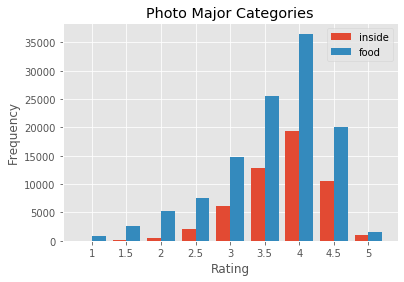

In [62]:
N = 9
ind = np.arange(N)
width = 0.4
plt.bar(ind 
        , df_star_all.inside
        , width
        , label='inside')
plt.bar(ind + 1 * width
        , df_star_all.food
        , width
        , label='food')
plt.xticks(ind + width/2, (1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5))
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Photo Major Categories')
plt.savefig('photo_ctn_major_cat.png')
plt.show();

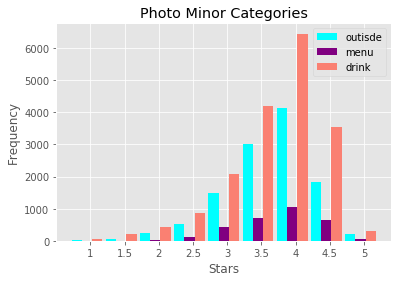

In [63]:
N = 9
ind = np.arange(N)
width = 0.3
plt.bar(ind - 1 * width 
        , df_star_all.outside
        , width
        , label='outisde'
        , color='cyan')
plt.bar(ind + 0 * width
        , df_star_all.menu
        , width
        , label='menu'
        , color='purple')
plt.bar(ind + 1 * width
        , df_star_all.drink
        , width
        , label='drink'
        , color='salmon')
plt.xticks(ind + width/3, (1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5))
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Photo Minor Categories')
plt.savefig('Photo_ctn_minor_cat.png')
plt.show();

In [36]:
df.head(1)

,photo_id,buz_id,caption,label,name,review_count,stars,state
0,MllA1nNpcp1kDteVg6OGUw,rcaPajgKOJC2vo_l3xa42A,,inside,Bouchon,3859,4.0,NV


In [37]:
df_sort_review_ctn = df.sort_values(by=['review_count'],ascending=False)

In [38]:
df_sort_review_ctn.name.value_counts()[:20]

McDonald's                            6948
Filiberto's Mexican Food              1386
Chipotle Mexican Grill                1056
Symposium Cafe Restaurant & Lounge     824
Bacchanal Buffet                       823
Pizza Hut                              814
El Pollo Loco                          775
Denny's                                694
IHOP                                   666
KFC                                    654
Wicked Spoon                           642
Gordon Ramsay Hell's Kitchen           612
Applebee's Grill + Bar                 606
Pizzaiolo                              602
First Watch                            569
Pita Jungle                            511
Chick-fil-A                            486
Eggsmart                               478
Yardbird Southern Table & Bar          421
Sonic Drive-In                         421
Name: name, dtype: int64

In [39]:
df.stars.loc[df.name=="McDonald's"].median()

2.0

In [40]:
df.stars.loc[df.name=="Filiberto's Mexican Food"].median()

2.5

In [41]:
df.stars.loc[df.name=="Chipotle Mexican Grill"].median()

3.0

In [42]:
df.loc[df.name=="McDonald's"].label.value_counts()

food       6234
drink       580
inside       78
outside      53
menu          3
Name: label, dtype: int64

In [43]:
df.head(1)

,photo_id,buz_id,caption,label,name,review_count,stars,state
0,MllA1nNpcp1kDteVg6OGUw,rcaPajgKOJC2vo_l3xa42A,,inside,Bouchon,3859,4.0,NV


In [44]:
df['photo_path'] = '/home/david/Downloads/photos/'+ df.photo_id + '.jpg'

In [45]:
df.head(1)

,photo_id,buz_id,caption,label,name,review_count,stars,state,photo_path
0,MllA1nNpcp1kDteVg6OGUw,rcaPajgKOJC2vo_l3xa42A,,inside,Bouchon,3859,4.0,NV,/home/david/Downloads/photos/MllA1nNpcp1kDteVg...


In [94]:
df['stars_str'] = df.stars.astype('int')

In [99]:
df['stars_str'] = df.stars.astype('str')

In [100]:
df['stars_str'].iloc[0]

'4.0'

In [46]:
df.label.value_counts()

food       114874
inside      52448
drink       18121
outside     11534
menu         3023
Name: label, dtype: int64

In [47]:
df_short_balanced = df.groupby('label').apply(lambda x: x.sample(n=3023)).reset_index(drop=True)

In [48]:
X = [load_img(df_short_balanced.photo_path.iloc[x]
                      , grayscale=True
                      , target_size=(128,128)) for x in range(len(df_short_balanced))]

In [49]:
photo_arr = []
for i in range(len(df_short_balanced)):
    photo_arr.append(img_to_array(X[i]).flatten())

In [50]:
photo_arr[0]

array([10.,  6.,  6., ..., 45., 51., 59.], dtype=float32)

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(photo_arr
                                                    , df_short_balanced.stars.astype('int')
                                                    , stratify=df_short_balanced.stars
                                                    , random_state=42)

In [52]:
y_train.unique()

array([4, 3, 5, 2, 1])

# SGD Modeling

In [53]:
sgd_clf = SGDClassifier(random_state=42
                        , max_iter=1000
                        , tol=1e-3)

In [54]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [55]:
y_pred = sgd_clf.predict(X_test)

In [56]:
sgd_clf.score(X_test, y_test)

0.4789626885419423

In [57]:
# cross_val_score(sgd_clf, photo_arr, df_short_balanced.stars.astype('int'), cv=5)

In [58]:
sdg_cv_5_scores = np.array([0.46347107, 0.45469577, 0.4164737 , 0.45268034, 0.4184045 ])

In [59]:
sdg_cv_5_scores.mean()

0.441145076

In [60]:
sdg_cv_10_scores = np.array([0.45376486, 0.47886394, 0.35449735, 0.3994709 , 0.40410053,
       0.46296296, 0.49072848, 0.46092715, 0.41258278, 0.42213386])

In [64]:
sdg_cv_10_scores.mean()

0.434003281

In [78]:
photo_arr[0].shape

(16384,)

In [65]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import keras 

from sklearn.model_selection import train_test_split 
from keras.utils import to_categorical 

from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Dense, Dropout 
from keras.layers import Flatten, BatchNormalization

In [69]:
from keras.applications.inception_v3 import InceptionV3


In [79]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [106]:
# MODEL
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(255, 255, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(9))
model.add(Activation('sigmoid'))
# COMPILE
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [85]:
df.head(1)

,photo_id,buz_id,caption,label,name,review_count,stars,state,photo_path
0,MllA1nNpcp1kDteVg6OGUw,rcaPajgKOJC2vo_l3xa42A,,inside,Bouchon,3859,4.0,NV,/home/david/Downloads/photos/MllA1nNpcp1kDteVg...


In [ ]:
flow_from_dataframe(dataframe
                    , directory=None
                    , x_col='filename'
                    , y_col='class'
                    , weight_col=None
                    , target_size=(256, 256)
                    , color_mode='rgb'
                    , classes=None
                    , class_mode='categorical'
                    , batch_size=32
                    , shuffle=True
                    , seed=None
                    , save_to_dir=None
                    , save_prefix=''
                    , save_format='png'
                    , subset=None
                    , interpolation='nearest'
                    , validate_filenames=True)

In [102]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_dataframe(df
                                                    , x_col='photo_path'  # this is the target directory
                                                    , y_col='stars_str'
                                                    , target_size=(255, 255)  # all images will be resized to 300x300
                                                    , batch_size=batch_size
                                                    , class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_dataframe(df
                                                        , x_col='photo_path'
                                                        , y_col='stars_str'
                                                        , target_size=(255, 255)
                                                        , batch_size=batch_size
                                                        , class_mode='categorical')

Found 200000 validated image filenames belonging to 9 classes.
Found 200000 validated image filenames belonging to 9 classes.


In [113]:
# TRAINING
results = model.fit_generator(train_generator
                              , steps_per_epoch=400 // batch_size
                              , epochs=50
                              , validation_data=validation_generator
                              , validation_steps=160 // batch_size)

model.save_weights('50_epochs.h5')  # always save your weights after training or during training

Epoch 1/50
25/25 [==============================] - 32s 1s/step - loss: 0.3084 - accuracy: 0.8872 - val_loss: 0.3386 - val_accuracy: 0.8889
Epoch 2/50
25/25 [==============================] - 31s 1s/step - loss: 0.2977 - accuracy: 0.8892 - val_loss: 0.2707 - val_accuracy: 0.8889
Epoch 3/50
25/25 [==============================] - 29s 1s/step - loss: 0.3042 - accuracy: 0.8875 - val_loss: 0.3152 - val_accuracy: 0.8889
Epoch 4/50
25/25 [==============================] - 28s 1s/step - loss: 0.3009 - accuracy: 0.8872 - val_loss: 0.3037 - val_accuracy: 0.8889
Epoch 5/50
25/25 [==============================] - 27s 1s/step - loss: 0.2842 - accuracy: 0.8889 - val_loss: 0.2662 - val_accuracy: 0.8889
Epoch 6/50
25/25 [==============================] - 28s 1s/step - loss: 0.2963 - accuracy: 0.8889 - val_loss: 0.2357 - val_accuracy: 0.8896
Epoch 7/50
25/25 [==============================] - 28s 1s/step - loss: 0.2956 - accuracy: 0.8883 - val_loss: 0.2877 - val_accuracy: 0.8889
Epoch 8/50
25/25 [==

''

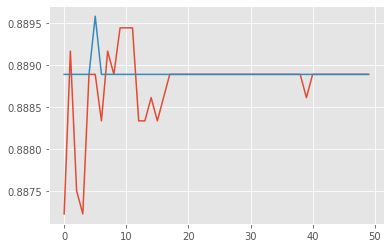

In [142]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
;

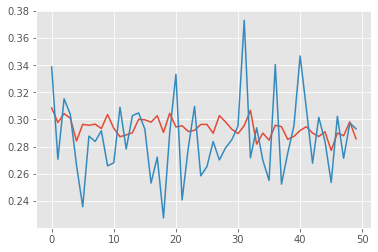

In [143]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss']);

In [115]:
train_generator.class_indices

{'1.0': 0,
 '1.5': 1,
 '2.0': 2,
 '2.5': 3,
 '3.0': 4,
 '3.5': 5,
 '4.0': 6,
 '4.5': 7,
 '5.0': 8}

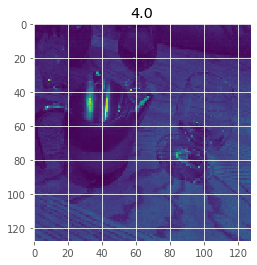

In [118]:
plt.imshow(X[0])
plt.title(df.stars_str.iloc[0]);

In [120]:
import numpy as np
from keras.preprocessing import image

In [131]:
file_1 = df.photo_path.iloc[0]

def pred_img(file=file_1):
    predicted_img = image.load_img(file, target_size=(255, 255))
    predicted_img = image.img_to_array(predicted_img)
    predicted_img = np.expand_dims(predicted_img, axis=0)
    predicted_img = predicted_img/255
    prediction_prob = model.predict(predicted_img)
    print(f'Class Predicted: {model.predict_classes(predicted_img)[0]}')
    print(f'Probability that food image is of the selected one is: {prediction_prob[0][0]}')

In [134]:
predicted_img = image.load_img(file_1, target_size=(255, 255))
predicted_img = image.img_to_array(predicted_img)
predicted_img = np.expand_dims(predicted_img, axis=0)
predicted_img = predicted_img/255
prediction_prob = model.predict(predicted_img)
print(f'Class Predicted: {model.predict_classes(predicted_img)[0] * 0.5 + 1}')
print(f'Probability: {prediction_prob[0]}')

Class Predicted: 4.0
Probability: [2.13575971e-04 1.94453378e-03 8.78654793e-03 3.34859826e-02
 1.18456475e-01 2.41366699e-01 3.51113111e-01 1.75320119e-01
 4.70301509e-03]
